# Gyroscope DDPG reward function testing (spinup library)

In [2]:
import gym
from gym import spaces
from gym.utils import seeding
import numpy as np
from os import path
from scipy.integrate import solve_ivp
import pandas as pd

import gym_gyroscope_env
import spinup
import torch
from functools import partial

from custom_functions.custom_functions import env_fn 
from custom_functions.custom_functions import create_env
from custom_functions.custom_functions import load_agent
from custom_functions.custom_functions import test_agent
from custom_functions.custom_functions import plot_test
from custom_functions.custom_functions import evaluate_control

import random
from collections import deque
import matplotlib.pyplot as plt
%matplotlib inline

In /home/xiongyan/anaconda3/envs/spinningup/lib/python3.6/site-packages/matplotlib/mpl-data/stylelib/_classic_test.mplstyle: 
The text.latex.preview rcparam was deprecated in Matplotlib 3.3 and will be removed two minor releases later.
In /home/xiongyan/anaconda3/envs/spinningup/lib/python3.6/site-packages/matplotlib/mpl-data/stylelib/_classic_test.mplstyle: 
The mathtext.fallback_to_cm rcparam was deprecated in Matplotlib 3.3 and will be removed two minor releases later.
In /home/xiongyan/anaconda3/envs/spinningup/lib/python3.6/site-packages/matplotlib/mpl-data/stylelib/_classic_test.mplstyle: Support for setting the 'mathtext.fallback_to_cm' rcParam is deprecated since 3.3 and will be removed two minor releases later; use 'mathtext.fallback : 'cm' instead.
In /home/xiongyan/anaconda3/envs/spinningup/lib/python3.6/site-packages/matplotlib/mpl-data/stylelib/_classic_test.mplstyle: 
The validate_bool_maybe_none function was deprecated in Matplotlib 3.3 and will be removed two minor rele

## Plot rewards

In [3]:
def read_progress(agent_path):
    
    # count lines
    file = open(agent_path+"/progress.txt", "r")
    count = len(file.readlines())
    data = np.empty([count-1, 19])
    file.seek(0)
    
    # read each line as a numpy array
    for row, x in enumerate(file):
        if row == 0:
            continue
        data[row-1] = np.array(x.split('\t')).astype(np.float)
    file.close()
    
    return data

iter0_base 2000
iter0_reward01 2000
iter0_reward02 2000
iter0_reward03 2000
iter0_rs01 2000
iter0_rs02 2000
iter0_gamma01 2000
iter0_gamma02 2000
iter0_gamma03 2000
iter0_polyak01 2000
iter0_polyak02 2000
iter0_polyak03 2000
iter0_lr01 2000
iter0_lr02 2000
iter0_bs01 2000
iter0_bs02 2000
iter0_ss01 2000
iter0_ss02 2000
iter0_noise01 2000
iter0_noise02 2000


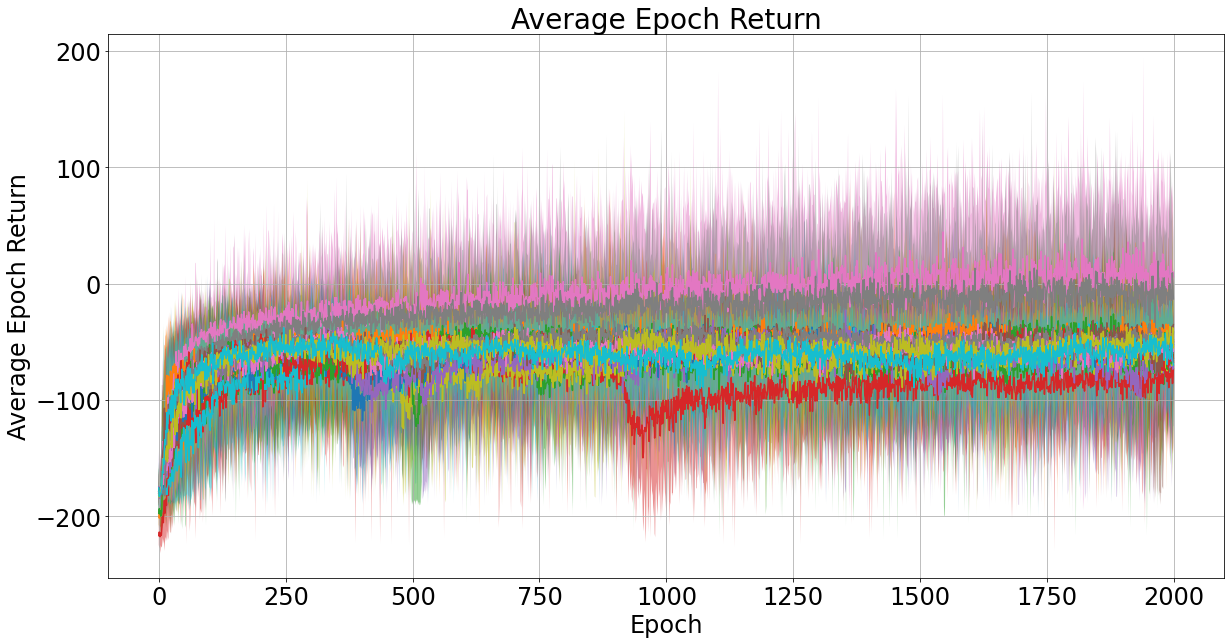

In [4]:
plt.figure(figsize=(20,10))
plt.title('Average Epoch Return',fontsize=28)
plt.xlabel('Epoch',fontsize=24)
plt.xticks(fontsize=24)
plt.ylabel('Average Epoch Return',fontsize=24)
plt.yticks(fontsize=24)
plt.grid()

agent_paths = ['iter0_base','iter0_reward01','iter0_reward02','iter0_reward03',
              'iter0_rs01','iter0_rs02','iter0_gamma01','iter0_gamma02','iter0_gamma03',
              'iter0_polyak01','iter0_polyak02','iter0_polyak03','iter0_lr01','iter0_lr02',
              'iter0_bs01','iter0_bs02','iter0_ss01','iter0_ss02','iter0_noise01','iter0_noise02']

for agent_path in agent_paths:
    progress = read_progress(agent_path)
    print(agent_path, len(progress))
    plt.plot(np.arange(progress.shape[0]), progress[:,1])
    plt.fill_between(np.arange(progress.shape[0]), progress[:,3], progress[:,4], alpha=0.5)
#     plt.fill_between(np.arange(progress.shape[0]), progress[:,1]+progress[:,2], progress[:,1]-progress[:,2], alpha=0.5)

# plt.xlim([0,500])
# plt.ylim([-2000,0])
# plt.legend(agent_paths,fontsize=24)

## Test an agent

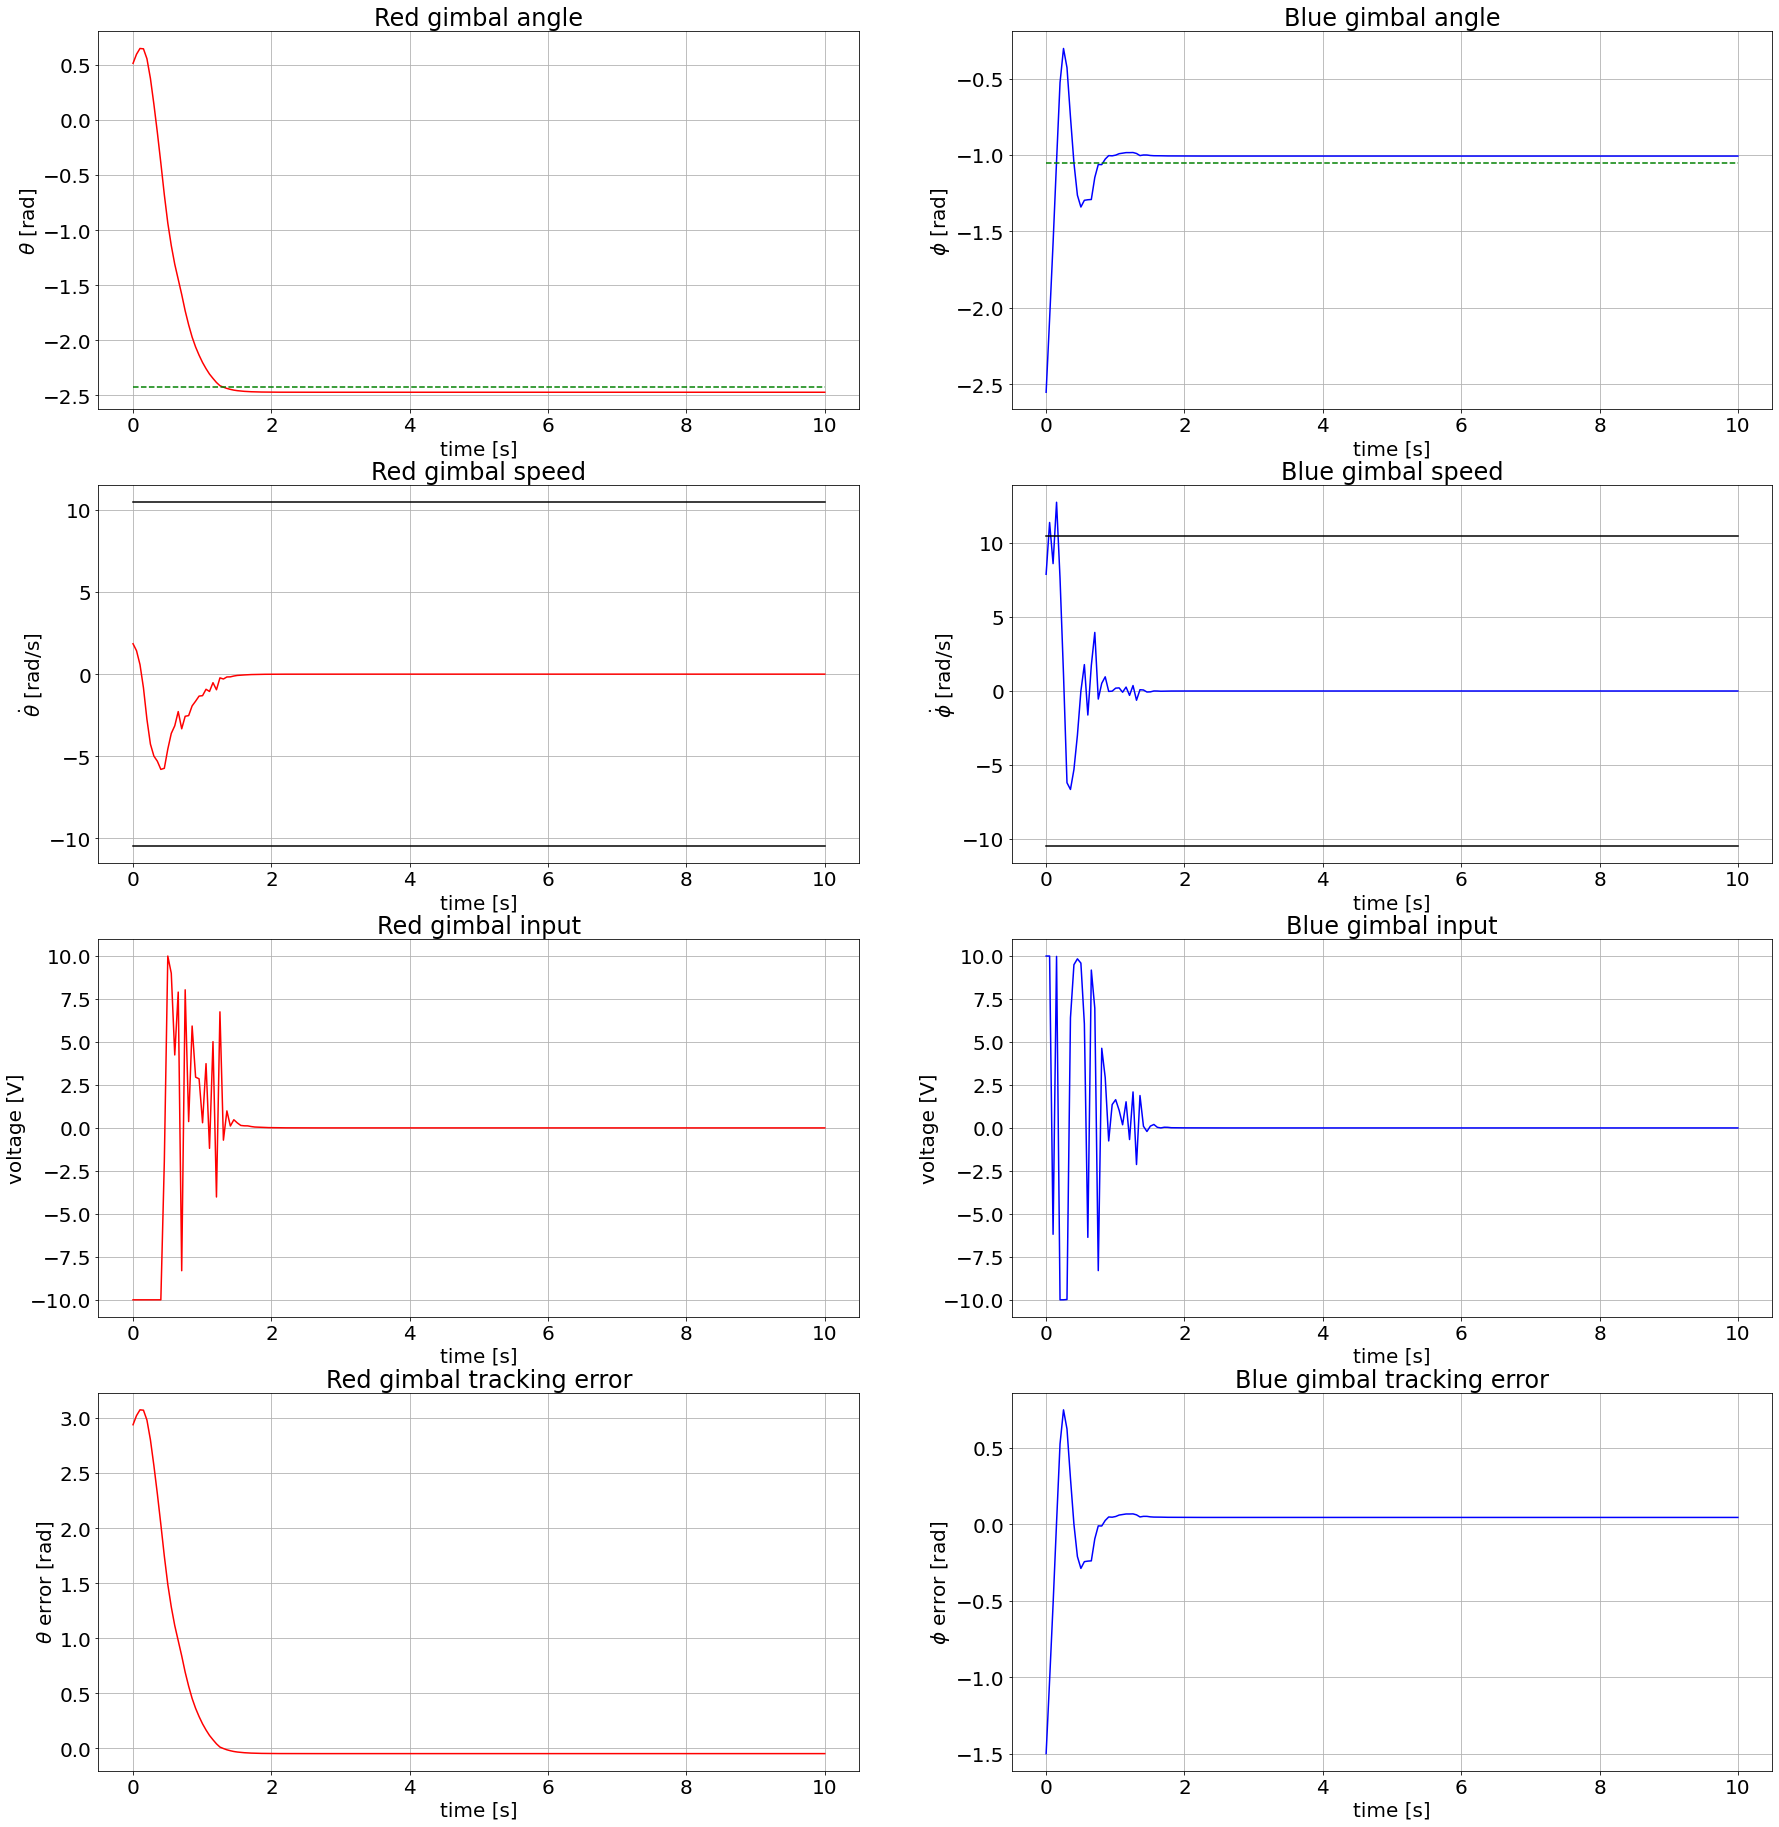

In [12]:
# Test paramaters
env_name = 'GyroscopeEnv-v1'
simu_args = {
    'dt': 0.05,
    'ep_len': 100,
    'seed': 2
}
reward_func = 'Sparse with exp'
reward_args = {
    'qx1': 1, 
    'qx2': 0, 
    'qx3': 1, 
    'qx4': 0, 
    'pu1': 0, 
    'pu2': 0,
    'e': 10,
    'bound': 0.001,
    'reward': 10
}

# init_state = np.array([0,0,0,0,200/60*2*np.pi,45/180*np.pi,-60/180*np.pi])
env = create_env(env_name,simu_args,reward_func,reward_args,state=None)

agent_paths = ['iter0_base','iter0_reward01','iter0_reward02','iter0_reward03',
              'iter0_rs01','iter0_rs02','iter0_gamma01','iter0_gamma02','iter0_gamma03',
              'iter0_polyak01','iter0_polyak02','iter0_polyak03','iter0_lr01','iter0_lr02',
              'iter0_bs01','iter0_bs02','iter0_ss01','iter0_ss02','iter0_noise01','iter0_noise02']

agent = load_agent(agent_paths[4])
t_end = 10

score, state_record, obs_record, action_record, reward_record = test_agent(env,agent,t_end)
plot_test(state_record, action_record, t_end, 4)

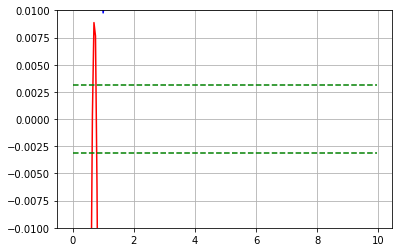

In [5]:
time = np.arange(0,10,0.05)
plt.plot(time, env.angle_normalize(state_record[:,0] - state_record[:,4]),'r')
plt.plot(time, env.angle_normalize(state_record[:,2] - state_record[:,5]),'b')
plt.plot(time, [np.pi/1000]*len(time), 'g--')
plt.plot(time, [-np.pi/1000]*len(time), 'g--')
plt.ylim([-0.01,0.01])
plt.grid()

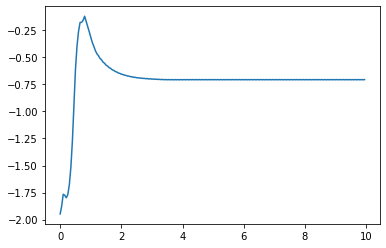

In [6]:
plt.plot(time, reward_record)

## Evaluate control performance

In [7]:
iter0_metrics = pd.read_csv('iter0_metrics.csv')
pd.set_option('display.max_columns', None)
iter0_metrics

,Unnamed: 0,iter0_base,iter0_reward01,iter0_reward02,iter0_reward03,iter0_rs01,iter0_rs02,iter0_gamma01,iter0_gamma02,iter0_gamma03,iter0_polyak01,iter0_polyak02,iter0_polyak03,iter0_lr01,iter0_lr02,iter0_bs01,iter0_bs02,iter0_ss01,iter0_ss02,iter0_noise01,iter0_noise02
0,$\theta$ MAE (rad),0.1585,0.1198,0.1603,0.1528,0.1689,0.1163,0.1037,0.0977,0.1743,0.1502,0.1638,0.1257,0.1806,0.1831,0.1607,0.1634,0.1431,0.1167,0.1268,0.1892
1,$\phi$ MAE (rad),0.1173,0.1012,0.1588,0.1449,0.2004,0.1106,0.0723,0.0665,0.1581,0.1273,0.1069,0.1180,0.1501,0.1477,0.1609,0.1460,0.1429,0.1234,0.1246,0.1279
2,$\theta$ MSSE (rad),0.0881,0.0462,0.0738,0.0771,0.0732,0.0459,0.0153,0.0182,0.1007,0.0641,0.0919,0.0408,0.0928,0.1074,0.0728,0.0728,0.0575,0.0440,0.0456,0.1076
3,$\phi$ MSSE (rad),0.0454,0.0445,0.0710,0.0916,0.1236,0.0539,0.0086,0.0148,0.0981,0.0583,0.0489,0.0518,0.0702,0.0788,0.0752,0.0771,0.0639,0.0640,0.0665,0.0640
4,$\theta$ in bounds (%),93.8300,99.3500,94.3200,96.1500,89.8600,98.4400,99.5300,99.7700,93.7400,97.3400,94.4700,98.5000,86.9000,89.2600,87.4000,89.5700,96.5500,99.3600,98.2700,87.0800
5,$\phi$ in bounds (%),89.8700,96.1100,85.9200,93.2400,78.6900,98.3400,99.6600,99.9100,88.5100,93.4100,94.1800,97.4100,90.7300,88.5400,87.4500,91.1100,91.7600,92.7700,96.1800,85.8200
6,$\theta$ unsteady (%),1.5800,0.0200,1.3900,0.1700,6.3800,0.0400,0.1200,0.0400,0.4200,0.9700,0.3900,0.3500,1.9500,1.3700,5.7200,4.0200,0.9000,0.4200,0.1700,2.4100
7,$\phi$ unsteady (%),9.2000,3.3800,10.0500,3.5600,8.9700,1.5100,0.1800,0.0900,7.2800,5.7300,5.6100,0.5500,6.1900,7.2000,8.5600,6.3400,5.7600,5.1100,1.1100,12.0600
8,$\theta$ rise time (s),0.4836,0.4960,0.5386,0.5373,0.5496,0.4771,0.4866,0.4681,0.5287,0.5358,0.5057,0.5038,0.5192,0.5189,0.5067,0.5220,0.4954,0.4708,0.5296,0.5646
9,$\phi$ rise time (s),0.3502,0.3222,0.3717,0.3247,0.3555,0.3275,0.3451,0.2978,0.3257,0.3241,0.3147,0.3702,0.3540,0.3377,0.3521,0.3151,0.3391,0.3263,0.3554,0.3477
